In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from clustering import make_clustering
from tasks.feature_ignored import make_task
shap.initjs()
%matplotlib inline

In [2]:
clf_a, clf_b, X, y, feature_names, feature_precisions = make_task()

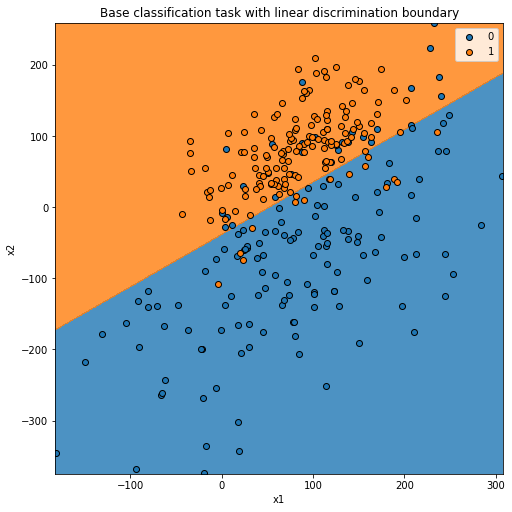

In [3]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=clf_a.predict, class_names=clf_a.classes_,
                       fig=fig, ax=ax)

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

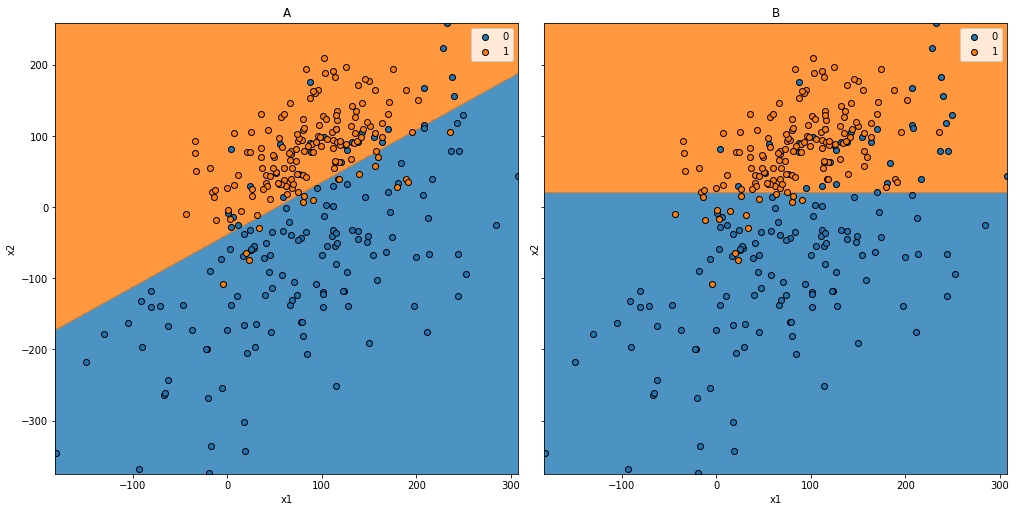

In [5]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

In [6]:
clf_a.coef_, clf_a.intercept_

(array([[-0.02146303,  0.02909487]]), array([1.11018683]))

In [7]:
clf_b.coef_, clf_b.intercept_

(array([[0.        , 0.01784651]]), array([-0.38103095]))

In [8]:
x2_lim = -clf_b.intercept_[0]/clf_b.coef_[0][1]
x2_lim

21.35044499661792

In [9]:
x1_where_x2_crosses = (-clf_a.intercept_[0] - clf_a.coef_[0][1]*x2_lim)/clf_a.coef_[0][0]
x1_where_x2_crosses

80.66778961788788

In [10]:
-clf_a.intercept_[0]/clf_a.coef_[0][1]

-38.15747075547969

In [11]:
-clf_a.coef_[0][0]/clf_a.coef_[0][1]

0.7376911656310202

A logistic regression model discriminates at 0, therefore the decision boundary is given by the function $\beta_0 + \beta_1 x_1 + \beta_2 x_2 = 0$

The decision boundary for A can be expressed as a function of $x_1$: $f(x_1) = -\frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta_2}x_1$

Since for B it is true that $\beta_1=0$, then the decision boundary is given by $x_2^*=\frac{-\beta_0}{\beta_2}$

- $x_1 > 80.67 \land 21.35 < x2 \leq -38.16 + 0.74 x_1$
- $x_1 \leq 80.67 \land -38.16 + 0.74 x_1 < x2 \leq 21.35$

In [12]:
(-clf_a.intercept_[0] - clf_a.coef_[0][0] * 200)/clf_a.coef_[0][1]

109.38076237072437

In [13]:
-38.15747075547969 + 0.7376911656310202*200

109.38076237072434

In [14]:
comparer.predict_bin_diff([[200, 110]])

array([False])

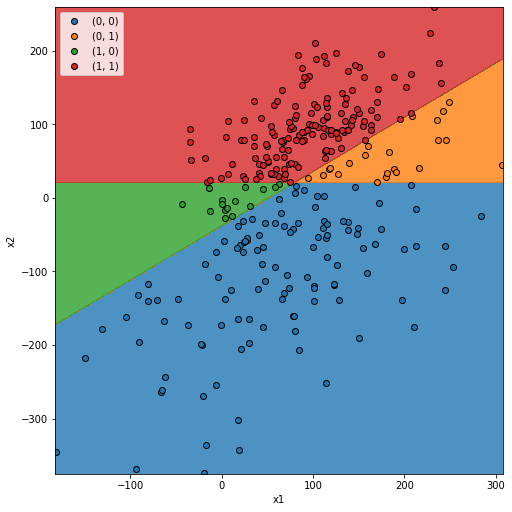

In [15]:
comparer.plot_decision_boundaries(X)

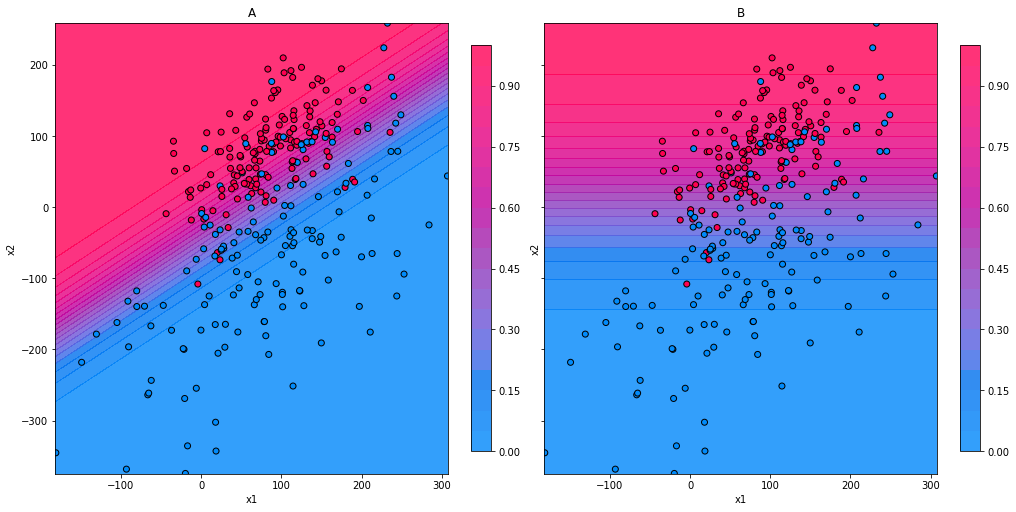

In [16]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba')

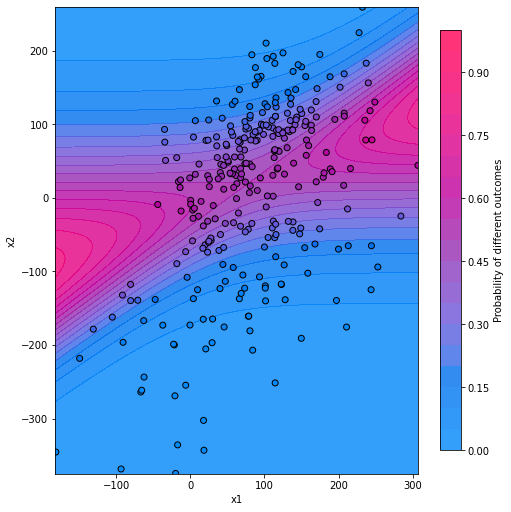

In [17]:
comparer.plot_decision_boundaries(X, kind='proba', type='bin-diffclf')

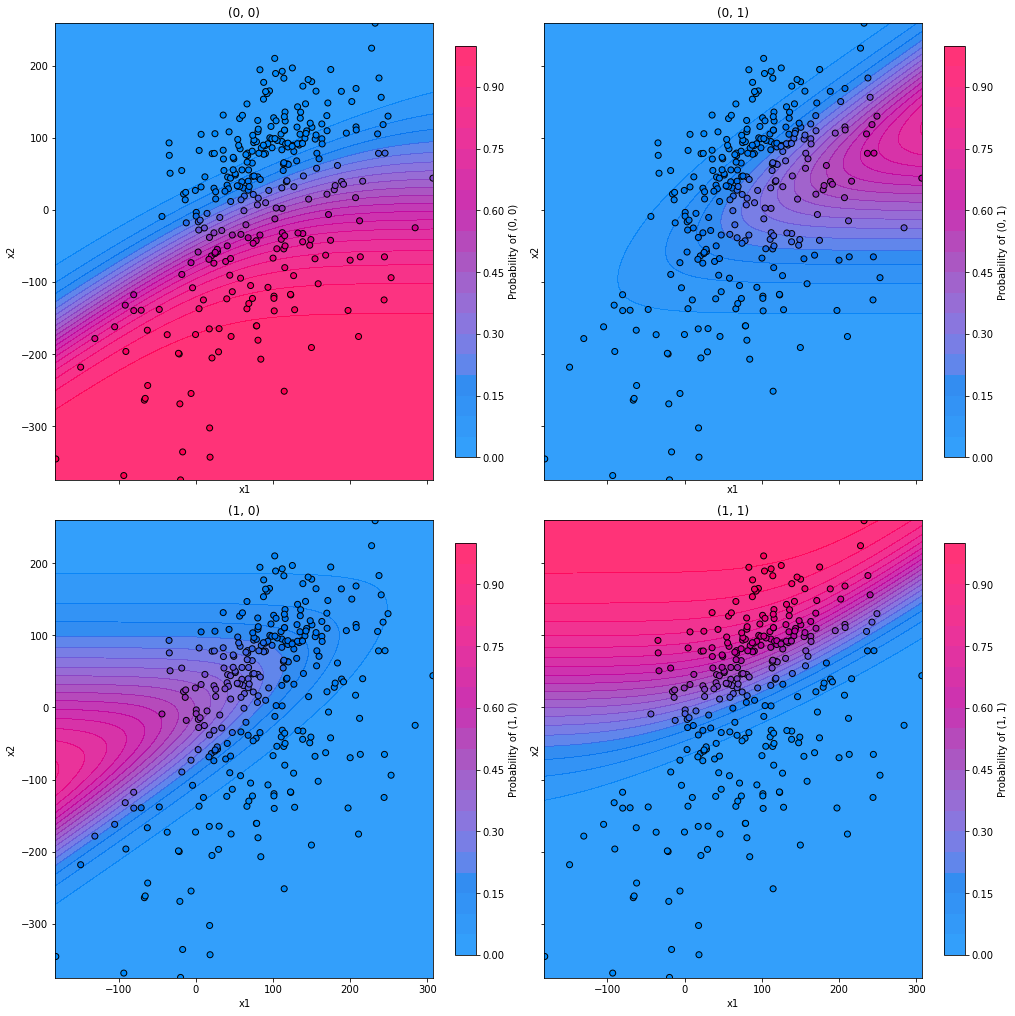

In [18]:
comparer.plot_decision_boundaries(X, kind='proba', type='mclass-diffclf')

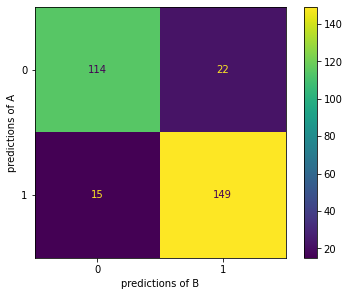

In [19]:
comparer.plot_confusion_matrix(X)

# Ground Truth

In [24]:
%%time
for label in comparer.difference_class_names:
    print(label)
    ground_truth_instance_indices, ground_truth = calc_ground_truth_constraints(comparer, feature_precisions, X, label)
    with open(f'ground_truth.{label}.pickle', 'wb') as f:
        pickle.dump((ground_truth_instance_indices, ground_truth), f)
    rules = constraint_matrix_to_rules(ground_truth, feature_names)
    for instance_idx, rule in zip(ground_truth_instance_indices, rules):
        print(f'{instance_idx}: {rule}')
    print()

(0, 1)
44: x1 > 111.3 and 21.3 < x2 <= 188.4
51: x1 > 147.7 and 21.3 < x2 <= 79.6
58: x1 > 158.4 and 21.3 < x2 <= 142.7
60: x1 > 89.5 and 21.3 < x2 <= 94.2
69: x1 > 135.2 and 21.3 < x2 <= 97.2
78: x1 > 129.9 and 21.3 < x2 <= 77.3
96: x1 > 104.6 and 21.3 < x2 <= 48.4
148: x1 > 106.5 and 21.3 < x2 <= 49.0
170: x1 > 115.4 and 21.3 < x2 <= 64.7
177: x1 > 97.4 and 21.3 < x2 <= 95.0
195: x1 > 88.2 and 21.3 < x2 <= 31.5
207: x1 > 105.0 and 21.3 < x2 <= 101.1
221: x1 > 95.3 and 21.3 < x2 <= 55.6
224: x1 > 105.6 and 21.3 < x2 <= 121.3
229: x1 > 201.9 and 21.3 < x2 <= 115.1
236: x1 > 194.5 and 21.3 < x2 <= 135.6
241: x1 > 81.1 and 21.3 < x2 <= 87.2
246: x1 > 158.0 and 21.3 < x2 <= 136.4
249: x1 > 212.0 and 21.3 < x2 <= 140.8
269: x1 > 93.1 and 21.3 < x2 <= 44.0
275: x1 > 227.9 and 21.3 < x2 <= 145.5
296: x1 > 99.8 and 21.3 < x2 <= 103.0

(1, 0)
17: x1 <= 47.0 and -37.7 < x2 <= 21.3
19: x1 <= 17.6 and -29.9 < x2 <= 21.3
46: x1 <= 27.3 and -47.3 < x2 <= 21.3
128: x1 <= 77.8 and 8.2 < x2 <= 21.3
13

# Special Notes on Evaluation

This task serves to test the interpretability methods' generalization capabilities. Therefore, they will be used to create explanations on at least three different levels:
- global level: as simple as possible to describe the differences
    - 2 rules with 6 constraints achieve optimal selectiveness
- intermediate level(s): better fidelity but higher complexity than global level explanations
- local level: again better fidelity and higher complexity, but not too much complexity, so that they are still interpretable. Each method should state it's own rules as to how many rules to generate, I will evaluate afterwards which are more satisfying.

For the first time, probability estimates are available that can be made use of by the interpretability methods.